In [128]:
import numpy as np
import pandas as pd
import time
import graphlab as gl
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

## changing labels to 1 and -1. 0 is default for no-see on user-item

In [6]:
data.loc[data['is_listened']==0, 'is_listened'] = -1

## grouping on user-song with mean 'is_listened'. Try others things like latest listen value?

In [108]:
group_data = pd.DataFrame({'target': data.groupby(['user_id', 'media_id'])['is_listened'].mean()}).reset_index()

In [120]:
# user information sframe.
user_info = pd.DataFrame({'user_age': data.groupby(['user_id'])['user_age'].mean(),\
                          'user_gender': data.groupby(['user_id'])['user_gender'].mean()}).reset_index()

In [123]:
user_info = gl.SFrame(user_info)

## Convert to Sframe and split. Better split using graphlabs function?

In [114]:
data_sframe = gl.SFrame(group_data)

In [115]:
train_data, valid_data = gl.recommender.util.random_split_by_user(data_sframe, item_id='media_id', max_num_users=10000)

In [126]:
m = gl.ranking_factorization_recommender.create(train_data, user_id='user_id', \
                                                item_id='media_id', target='target', \
                                                binary_target=False, linear_regularization=0.00001, \
                                                regularization=0.00001, num_factors=32, ranking_regularization=0,\
                                                num_sampled_negative_examples=4)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 3576109 observations with 19879 users and 424437 items.

Data prepared in: 3.21038s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-05    |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 447013 / 3576109 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 2.06039           | Not Viable                               |

| 1       | 0.515099          | Not Viable                               |

| 2       | 0.128775          | 0.540207                                 |

| 3       | 0.0643873         | 0.533199                                 |

| 4       | 0.0321937         | 0.534776                                 |

| 5       | 0.0160968         | 0.54158                                  |

| 6       | 0.00804842        | 0.55965                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0643873         | 0.533199                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 0.815059          | 0.902806              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1.29s        | DIVERGED          | DIVERGED              | 0.0643873   |

| RESET   | 1.98s        | 0.815062          | 0.902808              |             |

| 1       | 2.97s        | 0.644106          | 0.770032              | 0.0321937   |

| 2       | 3.99s        | 0.61189           | 0.745625              | 0.0149649   |

| 3       | 4.94s        | 0.599857          | 0.734256              | 0.00974809  |

| 4       | 5.89s        | 0.595534          | 0.728758              | 0.00722829  |

| 5       | 6.83s        | 0.592833          | 0.7252                | 0.00574362  |

| 6       | 8.43s        | 0.591174          | 0.722683              | 0.00476491  |

| 9       | 12.16s       | 0.588947          | 0.718053              | 0.00315307  |

| 11      | 14.06s       | 0.588174          | 0.716098              | 0.00257286  |

| 14      | 17.21s       | 0.587451          | 0.713854              | 0.00201631  |

| 19      | 22.41s       | 0.586846          | 0.711264              | 0.001482    |

| 24      | 27.48s       | 0.586641          | 0.709443              | 0.00117155  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.587713

Final training RMSE: 0.709912

## Compute ROC score

In [127]:
val_pred = m.predict(valid_data)

valid_df = valid_data.to_dataframe()
valid_df.loc[valid_df['target'] >= 0, 'target']  = 1
valid_df.loc[valid_df['target'] < 0, 'target'] = 0

score = roc_auc_score(list(valid_df['target']), val_pred)
print score

0.824913508871


# Prediction and submission file

In [33]:
test_data_sframe = gl.SFrame.read_csv('data/test.csv')

Finished parsing file /Users/tushar/Desktop/Data Science Game/data/test.csv

Parsing completed. Parsed 100 lines in 0.097448 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,int,int,int,int,int,int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/tushar/Desktop/Data Science Game/data/test.csv

Parsing completed. Parsed 19918 lines in 0.09514 secs.

In [34]:
pred = m.predict(test_data_sframe)

In [35]:
submission_file_name = "deezer_predict_" + time.strftime("%Y%m%d_%H%M%S") + ".csv"
test_data['is_listened'] = pred

to_push = ["sample_id", "is_listened"]
test_data[to_push].to_csv(submission_file_name, index=False)

## Results on validation

In [ ]:
# 0.576197031625 for 10^-8
# 0.713714426378 for 10^-8 and modifying the input matrix
# 0.663766337849 for 10^-6 and modifying the input matrix
# 0.714364968875 for 10^-7 and modifying the input matrix
# 0.701378049512 for 10^-7 and modifying the input matrix and 10 latent factors
# 0.704926824027 for 10^-7 and modifying the input matrix and 60 latent factors: RMSE is less.
# 0.707957981743 for 10^-7 and modifying the input matrix and 60 latent factors: RMSE is less.
# 0.663387281063 for 10^-7 and modifying the input matrix and 25 latent factors.
# 0.651746652396 for 10^-7 and modifying the input matrix and neg_sampls = 6
# 0.714348039988 for 10^-7 and reg = 10-8 modifying the input matrix.
# 0.750114088083 for 10^-6 and reg = 10-8 modifying the input matrix.
# 0.778038465954 for 10^-5 and reg = 10-8 modifying the input matrix.
# 0.792415769025 for 10^-5 and reg = 10-5 modifying the input matrix.
# 0.79231144059 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=50.
# 0.791978838071 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=40.
# 0.792187575802 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=80.
# 0.792163807012 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=100.
# 0.792215850001 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=20.
# 0.79227342532 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=15.
# 0.824881834992 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=15, ranking_regularization=0.
# 0.818495085215 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=15, ranking_regularization=0.1.
# 0.750087546363 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=15, ranking_regularization=0.5.
# 0.825061387873 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0.
# 0.815397112278 for 10^-5 and reg = 10^-4 modifying the input matrix, ranking_regularization=0.
# 0.824878198452 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0 and num_sampled_ne_exm=6.
# 0.825013429366 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0 and num_sampled_ne_exm=9.
# 0.824995166848 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0 and num_sampled_ne_exm=15.
# 0.824992010313 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0 and num_sampled_ne_exm=15.
# 0.818962581465 for 10^-7 and reg = 10^-9 modifying the input matrix, ranking_regularization=0.












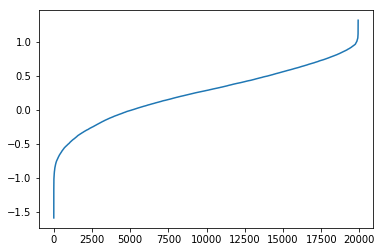

In [37]:
plt.plot(pred.sort())

# Ideas to explore

1. How to deal with multiple is_listen for user-song pair (currently mean) ? - Take latest.
2. Take into account other user/song data? - Try inbuilt parameters in this func.
3. How to leverage the temporal data given esp. for multiple user song pairs.
    - Maybe just take the latest time and target. But good only if test data after train.

## Ignore

In [17]:
from sklearn.cross_validation import train_test_split
data = data.loc[:100]
train_data, valid_data, train_labels, valid_labels = train_test_split(data[data.columns.difference(['is_listened'])], data['is_listened'], test_size=0.1)

In [20]:
from scipy.sparse import csr_matrix

users = list(train_data['user_id'])
media = list(train_data['media_id'])
train_labels.loc[train_labels == 0] = -1
listened_data = train_labels.tolist()
sparse_matrix = csr_matrix((listened_data, (users, media)))

In [24]:
sparse_matrix

<10703x900503 sparse matrix of type '<type 'numpy.int64'>'
	with 58 stored elements in Compressed Sparse Row format>

200058

In [13]:
# from scipy.sparse import csr_matrix

# users = list(data['user_id'])
# media = list(data['media_id'])
# data.loc[data['is_listened'] == 0, 'is_listened'] = -1
# listened_data = data['is_listened'].tolist()
# sparse_matrix = csr_matrix((listened_data, (users, media)))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# check. should be -1
sparse_matrix[9241, 222606]

-1

In [16]:
import implicit

In [17]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=20)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(sparse_matrix)

# recommend items for a user
# recommendations = model.recommend(userid, item_user_data.T)

# find related items
# related = model.similar_items(itemid)

ValueError: Buffer dtype mismatch, expected 'double' but got 'long long'

In [15]:
sparse_matrix

<16548x900503 sparse matrix of type '<type 'numpy.int64'>'
	with 61 stored elements in Compressed Sparse Row format>